# Unsupervised Time Series Analysis

https://tods-doc.github.io/index.html

F-Beta Score

supervised

https://medium.com/intel-tech/how-to-apply-transformers-to-time-series-models-spacetimeformer-e452f2825d2e


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

import os

In [2]:
import warnings
# warnings.simplefilter(action="ignore", category=UserWarning)

# Load Data

In [3]:
files = []

root_dir = "data/"
for file in os.listdir(root_dir):
    if file.endswith(".csv"):
        files.append("data/" + file)

files

['data/co2-1.csv', 'data/co2-2.csv', 'data/ele-1.csv', 'data/ele-2.csv']

In [4]:
def load_as_date_df(file_path:str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df["time"] = pd.to_datetime(df["time"])  # Convert "time" column to datetime
    df.set_index("time", inplace=True)  # Set "time" as the index
    return df

In [5]:
def graph_timeseries(input_df:pd.DataFrame):
    plt.figure(figsize=(9, 4))  
    fig = sns.lineplot(data=input_df) 
    plt.xlabel('Time')  
    plt.ylabel('PPM')  
    plt.xticks(rotation = 25)
    plt.figure(figsize=(20,5))


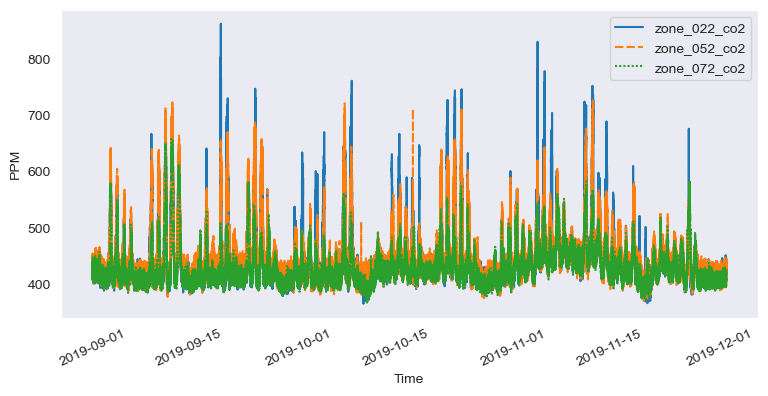

<Figure size 2000x500 with 0 Axes>

In [6]:
df = load_as_date_df(files[0])
graph_timeseries(df)

In [7]:
# from pyod.models.iforest import IForest

# transformer = IForest(n_estimators=100, max_samples='auto', contamination=0.1, max_features=1.0, bootstrap=False, n_jobs=1, random_state=None, verbose=0)

# Z-score

In [7]:
def find_outliers(input_df, threshold:int = 5)-> pd.DataFrame:
    df = input_df.copy()
    cols = df.columns.to_list()
    print(cols)
    out_cols:list = cols.copy()

    for col in cols:
        df["zscore_"+col] = stats.zscore(df[col])
        out_cols.append("outlier_"+col)
        df["outlier_"+col] = df["zscore_"+col] > threshold

    return df[out_cols]

def plot_outlier_timeseries(input_df, column_name, model_type:str='model'):
    fig, ax = plt.subplots(figsize=(11, 5))

    # Plot the original time series
    sns.lineplot(data=input_df[column_name], ax=ax,linewidth=0.75, color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765))

    # Overlay points where outlier is True
    outlier_points = input_df[input_df['outlier_'+column_name]]
    sns.scatterplot(x=outlier_points.index, y=outlier_points[column_name], color='red', ax=ax)

    # Set labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel(column_name)
    ax.set_title('Time Series with Outlier Highlighted by '+ model_type)
    ax.grid(True)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=25)

    # Show plot
    plt.show()

['zone_022_co2', 'zone_052_co2', 'zone_072_co2']


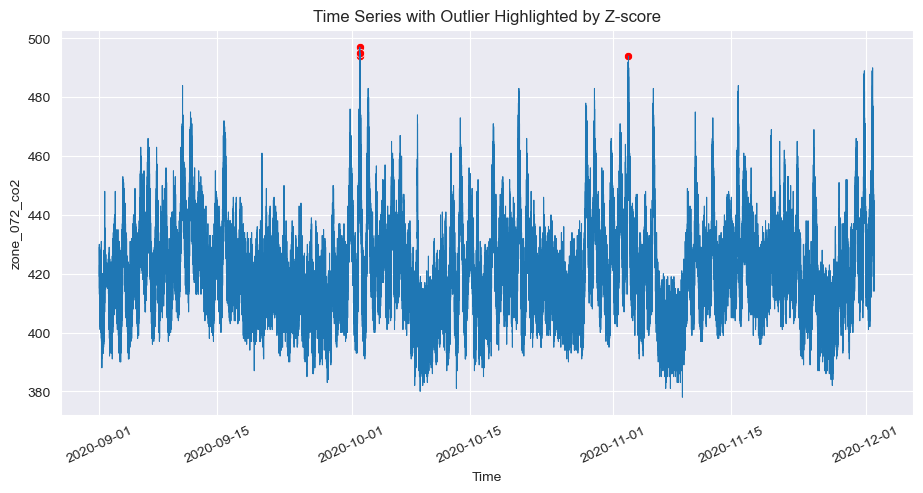

In [8]:
raw = load_as_date_df(files[1])
out = find_outliers(raw)
plot_outlier_timeseries(out, "zone_072_co2", "Z-score")

# Unsupervised Isolation Forest

In [9]:
def find_outliers_w_isolation_forest(input_df, contamination:float=0.005)-> pd.DataFrame:
    df = input_df.copy()
    cols = df.columns.to_list()
    print(cols)
    model = IsolationForest(
        n_estimators=200,
        contamination=contamination
    )

    for col in cols:
        model.fit(df[[col]])
        df["outlier_"+col] = model.predict(df[[col]])
        df['outlier_'+col] = df['outlier_'+col].apply(lambda x: True if x == -1 else False)

    return df

['zone_022_co2', 'zone_052_co2', 'zone_072_co2']


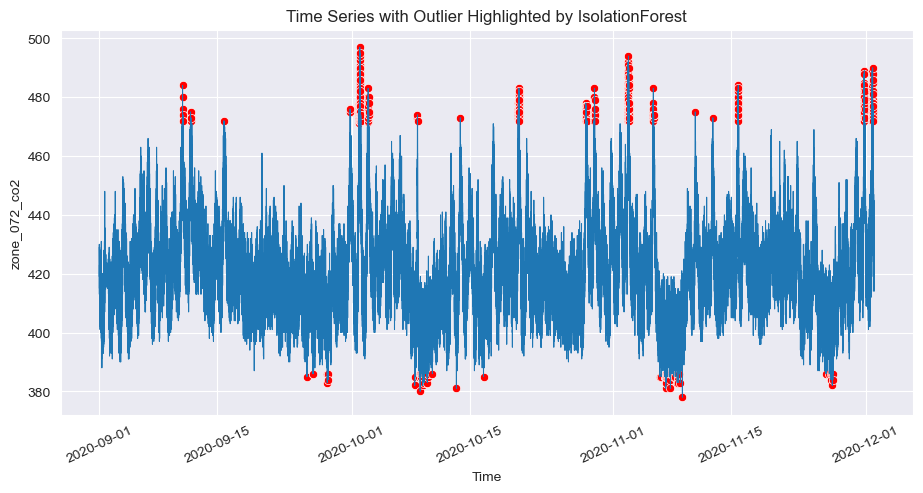

In [11]:
raw = load_as_date_df(files[1])
dd = find_outliers_w_isolation_forest(raw)
# [plot_outlier_timeseries(dd, col, "IsolationForest") for col in ['zone_022_co2', 'zone_052_co2', 'zone_072_co2']]
plot_outlier_timeseries(dd, "zone_072_co2", "IsolationForest")

# Unsupervised LocalOutlierFactor

In [12]:
def find_outliers_w_local_factor(input_df, contamination:float=0.01)-> pd.DataFrame:
    df = input_df.copy()
    cols = df.columns.to_list()
    print(cols)
    model = LocalOutlierFactor(
        n_neighbors=2,
        leaf_size=100,
        novelty=True,
        contamination=contamination
    )

    for col in cols:
        model.fit(df[[col]])
        df["outlier_"+col] = model.predict(df[[col]])
        df['outlier_'+col] = df['outlier_'+col].apply(lambda x: True if x == -1 else False)

    return df

['zone_022_co2', 'zone_052_co2', 'zone_072_co2']


/Users/gayathriselvaganapathi/miniconda3/envs/env_anomaly_detect/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/gayathriselvaganapathi/miniconda3/envs/env_anomaly_detect/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/gayathriselvaganapathi/miniconda3/envs/env_anomaly_detect/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


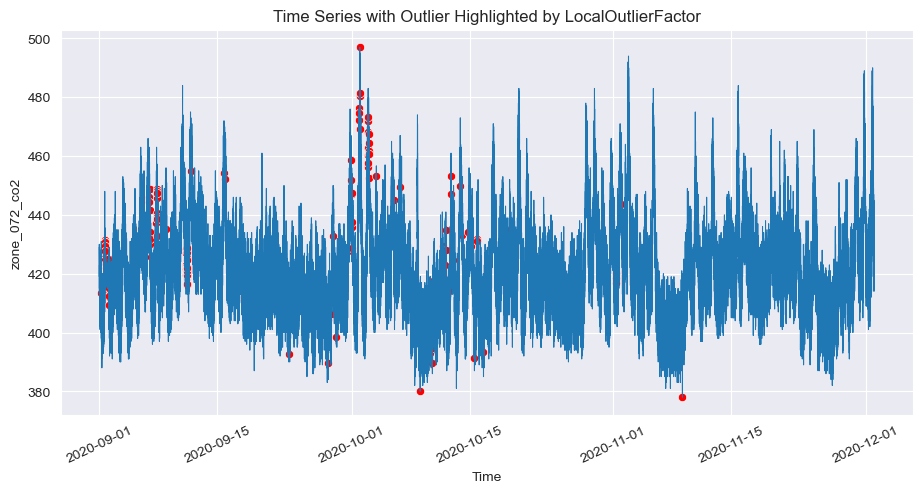

In [13]:
raw = load_as_date_df(files[1])
dd = find_outliers_w_local_factor(raw)
plot_outlier_timeseries(dd, "zone_072_co2", "LocalOutlierFactor")
# [plot_outlier_timeseries(dd, col, "LocalOutlierFactor") for col in ['zone_022_co2', 'zone_052_co2', 'zone_072_co2']]